In [198]:
import pandas as pd
import time
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

# Go up one directory to get to master/
project_root = str(Path.cwd().parent)
sys.path.append(project_root)


In [199]:
def get_solutions_all_folds_rollOCT(name_dataset: str, depth=3, folds_available = 10) -> dict: #for 10 fold cross valdidation, carefull that trees have min depth 2
    sol_dict = {} # one entry for every fold, [fold][depth]['test'] for train_data classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        for j in range(2,depth+1):
            sol_dict[i][j] = {}
            sol_dict[i][j]['test'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_test.csv")
            sol_dict[i][j]['train'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_train.csv")
    return sol_dict

#sol_dict = get_solutions_all_folds_pulp(name_dataset=name_dataset, depth= max_depth_available)

#print(sol_dict[4][8]['train'])

In [200]:
def get_solutions_all_folds_cart(name_dataset: str, depth=3, folds_available = 10) -> dict: #for 10 fold cross valdidation, carefull that trees have min depth 2
    sol_dict = {} # one entry for every fold, [fold][depth]['test'] for train_data classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        for j in range(2,depth+1):
            sol_dict[i][j] = {}
            sol_dict[i][j]['test'] = pd.read_csv(f"../results/{name_dataset}/cart/fold{i}/depth{j}_classification_{name_dataset}_test.csv")
            sol_dict[i][j]['train'] = pd.read_csv(f"../results/{name_dataset}/cart/fold{i}/depth{j}_classification_{name_dataset}_train.csv")
    return sol_dict

In [201]:
# get mcc list (one entry per fold) for specific depth 
def get_mcc_list(dataset_name, max_tree_depth, depth, folds_available, cart = False):
    if cart == False:
        sol_dict = get_solutions_all_folds_rollOCT(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)
    else:
        sol_dict = get_solutions_all_folds_cart(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)

    mcc_scores_test = []
    mcc_scores_train = []

    for fold in range(1, folds_available+1):
        
        y_true_test = sol_dict[fold][depth]['test']['y']
        y_predict_test = sol_dict[fold][depth]['test']['prediction']

        y_true_train = sol_dict[fold][depth]['train']['y']
        y_predict_train = sol_dict[fold][depth]['train']['prediction']
        
        mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
        mcc_train = matthews_corrcoef(y_true_train, y_predict_train)

        mcc_scores_test.append(mcc_test)
        mcc_scores_train.append(mcc_train)
    
    return mcc_scores_test, mcc_scores_train

In [202]:
def mcc_dict_all_data(list_names, max_tree_depth, depth, folds, cart = False):
    mcc_dict = dict() #entry contains list with #folds values
    for i, name in enumerate(list_names):
        mcc_dict[name] = dict()
        #mcc_dict[name]['test'] = dict()
        #mcc_dict[name]['train'] = dict()
        mcc_scores_test, mcc_scores_train = get_mcc_list(dataset_name = name, max_tree_depth = max_tree_depth, depth = depth, folds_available = folds, cart = cart)
        mcc_dict[name]['test'] = mcc_scores_test
        mcc_dict[name]['train'] = mcc_scores_train
    return mcc_dict



In [203]:
mcc_dict_adult = mcc_dict_all_data(list_names=['adult'], max_tree_depth=8, depth=8, folds=10, cart=False)

print(mcc_dict_adult)

{'adult': {'test': [0.4695389369145332, 0.5061971985133343, 0.49637984945632385, 0.461481033668597, 0.5070366590692688, 0.48123464053462334, 0.5136416628097795, 0.4970429886605685, 0.46253389098089653, 0.48043918483290476], 'train': [0.5199225069557608, 0.5172736660500434, 0.5167198533914965, 0.5212872272842977, 0.5201074805139916, 0.5223941113372258, 0.5170771861910358, 0.5192932317605927, 0.5191162609249773, 0.5175850399152137]}}


In [204]:
def figure_mcc_matplotlib(list_names, max_tree_depth, depth, folds, cart = False, in_sample = False, alias_dict = dict()):
    mcc_dict = mcc_dict_all_data(list_names = list_names, max_tree_depth = max_tree_depth, depth = depth, folds = folds, cart = cart)
    data = []
    n_list = []
    for key in alias_dict:
        n_list.append(alias_dict[key])
    if cart == False:
        method_name = 'rollOCT'
    else: 
        method_name = 'cart'
    if in_sample == False:
        var = 'test'
        var_name = 'out-of-sample'
    else:
        var = 'train'
        var_name = 'in-sample'
    for i,name in enumerate(list_names):
            data.append(mcc_dict[name][var])
    plt.figure(figsize=(12, 6))
    plt.boxplot(data, tick_labels=n_list)
    plt.ylabel("mcc")
    plt.title(f"{method_name} {var_name} mcc depth {depth}")
    plt.show()

In [205]:
import seaborn as sns

def figure_mcc_seaborne(list_names, max_tree_depth, depth, folds, cart = False, in_sample = False, alias_dict = dict()):
    mcc_dict = mcc_dict_all_data(list_names = list_names, max_tree_depth = max_tree_depth, depth = depth, folds = folds, cart = cart)
    df = pd.DataFrame()
    n_list = []
    for key in alias_dict:
        n_list.append(alias_dict[key])
    if cart == False:
        method_name = 'rollOCT'
    else: 
        method_name = 'cart'
    if in_sample == False:
        var = 'test'
        var_name = 'out-of-sample'
    else:
        var = 'train'
        var_name = 'in-sample'
    for i,name in enumerate(list_names):
            df[alias_dict[name]] = mcc_dict[name][var]
    df_melted = pd.melt(df, var_name='Dataset', value_name='mcc')
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Dataset',
                y='mcc',
                data=df_melted,
                linewidth=1.3,       # thicker box lines
                #notch=True,        # notched boxplot
                width=0.6,         # narrower boxes
                palette="Set2",     # color palette
                medianprops={'color': 'red', 'linewidth': 1},
                #meanprops={'marker': 'D', 'markerfacecolor': 'blue', 'markeredgecolor': 'black', 'markersize': 8} # Mean shown as blue diamond
                )    
    plt.title(f"{method_name} {var_name} mcc depth {depth}")
    plt.show()

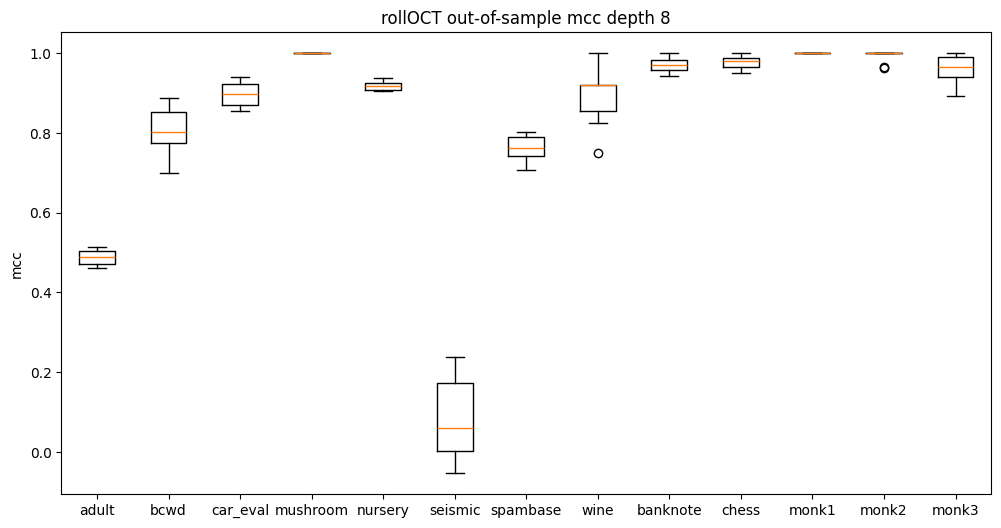

In [206]:
list_names = ['adult', 'breast+cancer+wisconsin+diagnostic', 'car_evaluation', 'mushroom', 'nursery', 'seismic', 'spambase', 'wine', 'banknote+authentication', 'chess+king+rook+vs+king+pawn', 'monk1', 'monk2', 'monk3']

alias_dict = {
    'adult' : 'adult',
    'breast+cancer+wisconsin+diagnostic' : 'bcwd',
    'car_evaluation' : 'car_eval',
    'mushroom' : 'mushroom',
    'nursery' : 'nursery',
    'seismic' : 'seismic',
    'spambase' : 'spambase',
    'wine' : 'wine',
    'banknote+authentication' : 'banknote',
    'chess+king+rook+vs+king+pawn' : 'chess',
    'monk1' : 'monk1',
    'monk2' : 'monk2',
    'monk3' : 'monk3'
}

figure_mcc_matplotlib(list_names, max_tree_depth = 8, depth=8, folds=10, cart = False, in_sample = False, alias_dict=alias_dict)

/tmp/ipykernel_19390/4074754898.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dataset',


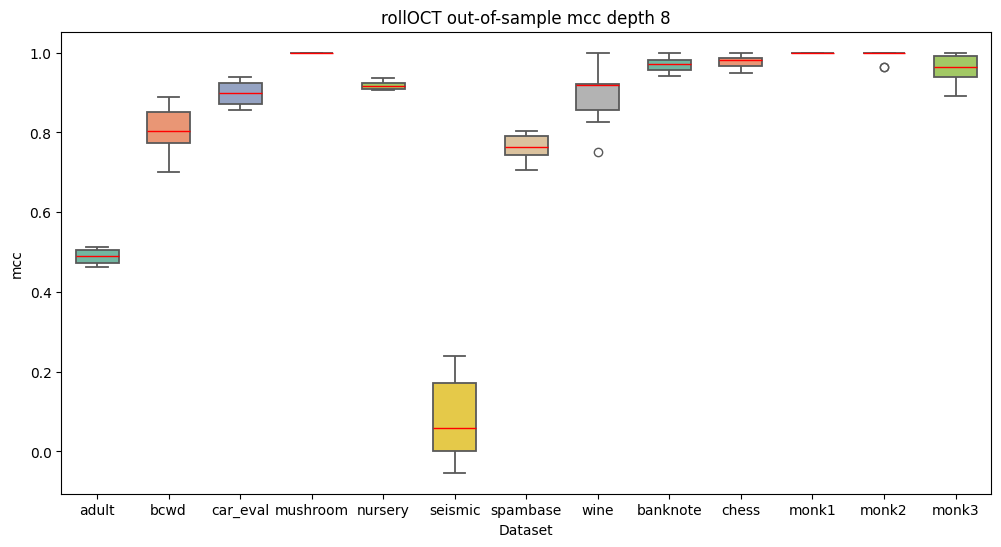

In [207]:
list_names = ['adult', 'breast+cancer+wisconsin+diagnostic', 'car_evaluation', 'mushroom', 'nursery', 'seismic', 'spambase', 'wine', 'banknote+authentication', 'chess+king+rook+vs+king+pawn', 'monk1', 'monk2', 'monk3']

alias_dict = {
    'adult' : 'adult',
    'breast+cancer+wisconsin+diagnostic' : 'bcwd',
    'car_evaluation' : 'car_eval',
    'mushroom' : 'mushroom',
    'nursery' : 'nursery',
    'seismic' : 'seismic',
    'spambase' : 'spambase',
    'wine' : 'wine',
    'banknote+authentication' : 'banknote',
    'chess+king+rook+vs+king+pawn' : 'chess',
    'monk1' : 'monk1',
    'monk2' : 'monk2',
    'monk3' : 'monk3'
}

figure_mcc_seaborne(list_names, max_tree_depth = 8, depth=8, folds=10, cart = False, in_sample = False, alias_dict=alias_dict)